# Comparison of measurements from different libraries

We now compare the implementation of the measurement `perimeter` in [napari-skimage-regionprops](https://github.com/haesleinhuepf/napari-skimage-regionprops) `regionprops_table` and [napari-simpleitk-image-processing](https://github.com/haesleinhuepf/napari-simpleitk-image-processing) `label_statistics`.

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
from pyclesperanto_prototype import imshow
from skimage import filters
from skimage import measure
import matplotlib.pyplot as plt
from napari_skimage_regionprops import regionprops_table
from skimage import filters
from napari_simpleitk_image_processing import label_statistics

C:\Users\maral\mambaforge\envs\feature_blogpost\lib\site-packages\morphometrics\measure\label.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Therefore, we need an `image` and a `label image`.

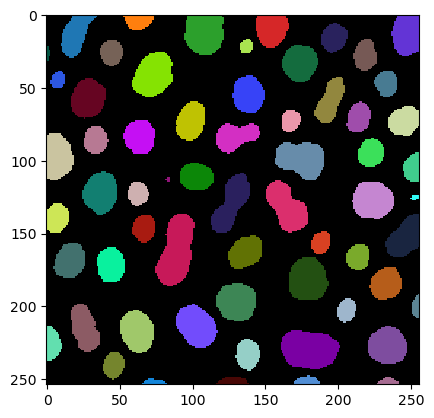

In [2]:
# load image
image = imread("../../data/blobs.tif")

# denoising
blurred_image = filters.gaussian(image, sigma=1)

# binarization
threshold = filters.threshold_otsu(blurred_image)
thresholded_image = blurred_image >= threshold

# labeling
label_image = measure.label(thresholded_image)

# visualization
imshow(label_image, labels=True)

We derive the perimeter measurements using the `regionprops_table` function

In [4]:
skimage_statistics = regionprops_table(image, label_image, perimeter = True)
skimage_statistics

,label,area,bbox_area,equivalent_diameter,convex_area,max_intensity,mean_intensity,min_intensity,perimeter,perimeter_crofton,standard_deviation_intensity
0,1,429,750,23.371345,479,232.0,191.440559,128.0,89.012193,87.070368,29.793138
1,2,183,231,15.264430,190,224.0,179.846995,128.0,53.556349,53.456120,21.270534
2,3,658,756,28.944630,673,248.0,205.604863,120.0,95.698485,93.409370,29.392255
3,4,433,529,23.480049,445,248.0,217.515012,120.0,77.455844,76.114262,35.852345
4,5,472,551,24.514670,486,248.0,213.033898,128.0,83.798990,82.127941,28.741080
...,...,...,...,...,...,...,...,...,...,...,...
57,58,213,285,16.468152,221,224.0,184.525822,120.0,52.284271,52.250114,28.255467
58,59,79,108,10.029253,84,248.0,184.810127,128.0,39.313708,39.953250,33.739912
59,60,88,110,10.585135,92,216.0,182.727273,128.0,45.692388,46.196967,24.417173
60,61,52,75,8.136858,56,248.0,189.538462,128.0,30.692388,32.924135,37.867411


... and using the `label_statistics` function

In [6]:
simpleitk_statistics = label_statistics(image, label_image, size = False, intensity = False, perimeter = True)
simpleitk_statistics

,label,perimeter,perimeter_on_border,perimeter_on_border_ratio
0,1,87.070368,16.0,0.183759
1,2,53.456120,21.0,0.392846
2,3,93.409370,23.0,0.246228
3,4,76.114262,20.0,0.262763
4,5,82.127941,40.0,0.487045
...,...,...,...,...
57,58,52.250114,0.0,0.000000
58,59,39.953250,18.0,0.450527
59,60,46.196967,22.0,0.476222
60,61,32.924135,15.0,0.455593


For this comparison, we are only interested in the column named `perimeter`. So we are selecting this column and convert the included measurements into a [numpy array](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/12_image_analysis_basics/01_Images_as_arrays.html):

In [15]:
skimage_perimeter = np.asarray(skimage_statistics['perimeter'])
simpleitk_perimeter = np.asarray(simpleitk_statistics['perimeter'])

## Scatter plot

If we now use [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) to plot the two perimeter measurements against each other, we receive the following scatter plot:

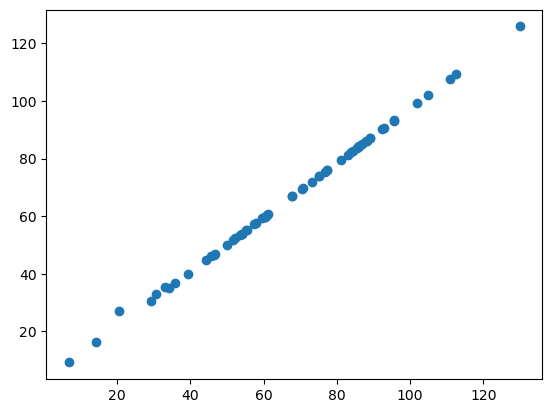

In [20]:
plt.plot(skimage_perimeter, simpleitk_perimeter, 'o')

If the two libraries would compute the perimeter in the same way, all of our datapoints would lie on a straight line. As you can see, they are not. This suggests that perimeter is implemented differently in [napari-skimage-regionprops](https://github.com/haesleinhuepf/napari-skimage-regionprops) and [napari-simpleitk-image-processing](https://github.com/haesleinhuepf/napari-simpleitk-image-processing).

## Bland-Altman plot

The [Bland-Altman plot](https://www.youtube.com/watch?v=PbSrSupnZFQ) helps to visualize the difference between measurements. We can compute a Bland-Altman plot for our two different `perimeter` implementations like this:

Text(0, 0.5, 'Difference of Measurement')

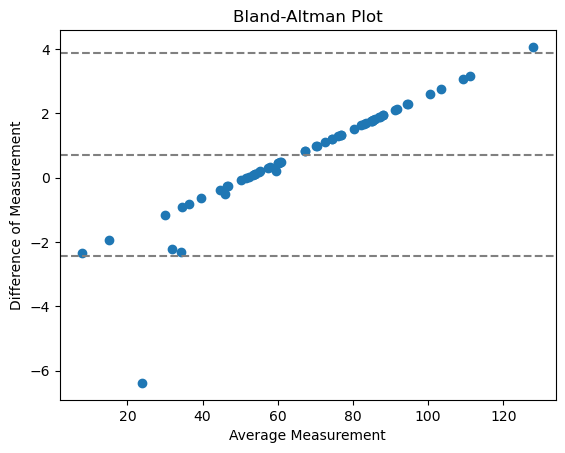

In [27]:
# compute mean, diff, md and sd
mean = (skimage_perimeter + simpleitk_perimeter) / 2
diff = skimage_perimeter - simpleitk_perimeter
md = np.mean(diff) # mean of difference
sd = np.std(diff, axis = 0) # standard deviation of difference

# add mean and diff
plt.plot(mean, diff, 'o')

# add lines
plt.axhline(md,           color='gray', linestyle='--')
plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

# add title and axes labels
plt.title('Bland-Altman Plot')
plt.xlabel('Average Measurement')
plt.ylabel('Difference of Measurement')

With 
- center line = mean difference between the methods
- two outer lines = confidence interval of agreement (_CI_)

The points do not go towards 0 which means it is not an agreement with random relative error, but systematic. This makes a lot of sense, because we are comparing here the __implementation__ of a measurement. 

# Exercise 

Use the functions `regionprops_table` and `label_statistics` to measure `feret_diameter_max` of your label image. Plot the Scatter plot and the Bland-Altman plot. Do you think `feret_diameter_max` is implemented differently in the two libraries?